In [1]:
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.models import load_model
from keras.layers import Bidirectional

from nltk.tokenize import word_tokenize
import pandas as pd 
import numpy as np
import re
import tensorflow as tf
from matplotlib import pyplot as plt



from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from numpy import array
from numpy import asarray
from numpy import zeros

### Loading Pickle files 

In [2]:
train_df = pd.read_pickle('train.pkl')
train_df.name = 'Train Dataset'
train_df.head()

,hmid,moment,social,agency
0,27674,i happy my son got marks his examination,1,0
1,27685,went movies my friends it fun,1,1
2,27691,hot kiss my girl friend last night made my day,1,1
3,27701,my son woke me fantastic breakfast eggs his sp...,1,0
4,27712,my older daughter keeps patting my younger dau...,1,0


In [3]:
test_df = pd.read_pickle('test.pkl')
test_df.name = "Test Dataset"
test_df.head()

,hmid,moment,social,agency
0,0,i able spend day my fiance shopping yesterday,0,1
1,1,i able play my cat,0,1
2,2,i able clean my room gold my laundry,0,1
3,3,i spend day party beach i happy see friends i ...,1,1
4,4,my cat greeting me i got home work she sweet c...,0,0


Seperating the X and y features for both the train and test dataset

In [4]:
X_train = train_df['moment'].values
y_train_social = train_df['social'].values
y_train_agency = train_df['agency'].values

In [5]:
X_test = test_df['moment'].values
y_test_social = test_df['social'].values
y_test_agency = test_df['agency'].values

#### Some statistical insights about our datasets

The TRAIN dataset

In [6]:
import statistics
length = 0
val = ""
train_avg = []
for sentence in X_train:
    sen_len = len(word_tokenize(sentence))
    train_avg.append(sen_len)
    if sen_len > length:
        length = sen_len
        val = sentence
print(f'Sentence : {val}\nLength :{length}')
print(f'Average Sentence Length : {sum(train_avg) / len(train_avg)}')
print(f'Standard Dev : {statistics.pstdev(train_avg)}') 

Sentence : it my th birthday i slept night i woke birthday morning i found my parents travelled my native my place my husband my kid arranged surprise birthday party i really moved my familys affection love they me made me really happy proud protected 
Length :43
Average Sentence Length : 9.144340288277391
Standard Dev : 4.58961222102695


The TEST dataset

In [7]:
length = 0
val = ""
test_avg = []
for sentence in X_test:
    sen_len = len(word_tokenize(sentence))
    test_avg.append(sen_len)
    if sen_len > length:
        length = sen_len
        val = sentence
print(f'Sentence : {val}\nLength :{length}')
print(f'Average Sentence Length : {sum(test_avg) / len(test_avg)}')

Sentence : event i would know it big small i bought my car made me happy long time hard work buy it i could it it made me happy past i tried raise money buy it everything resulted failure something damaged i buy something new even large part my money stolen i forgot my portfolio somewhere my nephew hid me my carelessness i lost money my father helped me replenish part money working long time i managed buy it i realized great effort i achieve anything i want 
Length :86
Average Sentence Length : 9.36282311937264


#### The following code block is used to : 
- Convert texts to sequence
- Then pad these sequences based on the max_len variable which is 25 in our case
- The max_len = 25 variable was choosen based on the criteria that majority of the sentences did fit under this value, which eventually enables us to have a dense matrix.
- Values 9 and 10 were also considered as the max_len val but did not produce promising results. They were choosen based on the fact that the average length of a sentence in this corpora is 9.36 (after text pre-processing)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 25

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
X_train.shape, X_test.shape

((9921, 25), (17215, 25))

#### Printing the top rows both text and numerical
- This gives us an idea of how the 1st value is converted to vector of 25 dimensions


In [10]:
print(train_df['moment'][0])
print(X_train[0])

i happy my son got marks his examination 
[   1    4    2   28    5 1819   37 1820    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


#### The following code block is used to build an embedding matrix with the following configuration

- Glove Embedding with 300 dimensions

In [11]:
embeddings_dictionary = dict()

glove_file = open('glove.6B/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Method to test the Accuracy, Precision, Recall and F1 Score


The following method transforms the output to binary values before calculating the scores

In [12]:
def transformResults(predictions):
    print("""The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0""")
    
    print("\nConverting the ouput to 1D array, and then transformimg the values based on the above condition\n")
    predictions = predictions[:, 0]
    print(f'First 5 values before conversion : {predictions[:5]}')
    
    predictions = [1 if val>0.5 else 0 for val in predictions]
    print(f'First 5 values after the conversion : {predictions[:5]}')
    return predictions

In [13]:
def getResults(y_test, model_prediction):
    model_prediction = transformResults(model_prediction)
    print("\n========== RESULTS ===========\n")
    accuracy = accuracy_score(y_test, model_prediction)
    precision = precision_score(y_test, model_prediction)
    f1 = f1_score(y_test, model_prediction)
    recall = recall_score(y_test, model_prediction)
    print(f'Accuracy : {accuracy}\nPrecision : {precision}\nF1_score : {f1}\nRecall : {recall}\n')
    
    print("===== CONFUSION MATRIX =====")
    cf_matrix = confusion_matrix(y_test_social, model_prediction)
    print(cf_matrix)
    
    return accuracy, precision, f1, recall

### Building the LSTM model 
with Embedding layer, LSTM layer and Dense layer with a single unit

This will be seperately evaluated for both the social and agency labels

In [14]:
def getLSTMModel():
    deep_inputs = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(deep_inputs)
    LSTM_Layer_1 = LSTM(128)(embedding_layer)
    dense_layer_1 = Dense(1, activation='sigmoid')(LSTM_Layer_1)
    model = Model(inputs=deep_inputs, outputs=dense_layer_1)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    print(model.summary())
    return model

In [15]:
model = getLSTMModel()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 300)           2178900   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,398,677
Trainable params: 219,777
Non-trainable params: 2,178,900
_________________________________________________________________
None


### Fit the model for the Social label

In [16]:
history = model.fit(X_train, y_train_social, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
62/62 [==============================] - 5s 56ms/step - loss: 0.5506 - acc: 0.6980 - val_loss: 0.2792 - val_acc: 0.8982
Epoch 2/10
62/62 [==============================] - 3s 43ms/step - loss: 0.2657 - acc: 0.9009 - val_loss: 0.2540 - val_acc: 0.9023
Epoch 3/10
62/62 [==============================] - 3s 43ms/step - loss: 0.2475 - acc: 0.9069 - val_loss: 0.2495 - val_acc: 0.9058
Epoch 4/10
62/62 [==============================] - 3s 44ms/step - loss: 0.2411 - acc: 0.9116 - val_loss: 0.2362 - val_acc: 0.9108
Epoch 5/10
62/62 [==============================] - 3s 45ms/step - loss: 0.2013 - acc: 0.9292 - val_loss: 0.2472 - val_acc: 0.9073
Epoch 6/10
62/62 [==============================] - 3s 44ms/step - loss: 0.1908 - acc: 0.9313 - val_loss: 0.2598 - val_acc: 0.9018
Epoch 7/10
62/62 [==============================] - 3s 45ms/step - loss: 0.1841 - acc: 0.9371 - val_loss: 0.2464 - val_acc: 0.9134
Epoch 8/10
62/62 [==============================] - 3s 46ms/step - loss: 0.1598 - a

In [17]:
predictions = model.predict(X_test)
print(predictions[:,0])

[0.98787105 0.20131403 0.20964587 ... 0.9888565  0.02677613 0.02373868]


In [18]:
social_results = getResults(y_test_social, predictions)

The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [0.98787105 0.20131403 0.20964587 0.9872048  0.94163674]
First 5 values after the conversion : [1, 0, 0, 1, 1]

========== RESULTS ===========

Accuracy : 0.9025268661051409
Precision : 0.9155578300921188
F1_score : 0.9142477514309076
Recall : 0.9129414166156359

===== CONFUSION MATRIX =====
[[6592  825]
 [ 853 8945]]


### Fit the model for the Agency Label

In [19]:
history = model.fit(X_train, y_train_agency, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
62/62 [==============================] - 3s 46ms/step - loss: 0.5767 - acc: 0.7535 - val_loss: 0.4457 - val_acc: 0.8045
Epoch 2/10
62/62 [==============================] - 3s 45ms/step - loss: 0.4199 - acc: 0.8250 - val_loss: 0.4037 - val_acc: 0.8186
Epoch 3/10
62/62 [==============================] - 3s 44ms/step - loss: 0.3657 - acc: 0.8465 - val_loss: 0.3780 - val_acc: 0.8403
Epoch 4/10
62/62 [==============================] - 3s 46ms/step - loss: 0.3385 - acc: 0.8561 - val_loss: 0.3686 - val_acc: 0.8418
Epoch 5/10
62/62 [==============================] - 3s 45ms/step - loss: 0.3186 - acc: 0.8633 - val_loss: 0.3581 - val_acc: 0.8423
Epoch 6/10
62/62 [==============================] - 3s 45ms/step - loss: 0.3143 - acc: 0.8663 - val_loss: 0.3614 - val_acc: 0.8448
Epoch 7/10
62/62 [==============================] - 3s 45ms/step - loss: 0.2934 - acc: 0.8754 - val_loss: 0.3713 - val_acc: 0.8413
Epoch 8/10
62/62 [==============================] - 3s 45ms/step - loss: 0.2809 - a

In [20]:
predictions = model.predict(X_test)
print(predictions[:,0])

[0.99298584 0.9937976  0.9938735  ... 0.54341716 0.94172114 0.9941218 ]


In [21]:
agency_results = getResults(y_test_agency, predictions)

The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [0.99298584 0.9937976  0.9938735  0.99229634 0.3139503 ]
First 5 values after the conversion : [1, 1, 1, 1, 0]

========== RESULTS ===========

Accuracy : 0.8271275050827767
Precision : 0.8541666666666666
F1_score : 0.8815097945532728
Recall : 0.9106614017769002

===== CONFUSION MATRIX =====
[[ 800 6617]
 [3455 6343]]


### ACCURACY scores for social and agency label with LSTM model

<Figure size 432x288 with 0 Axes>

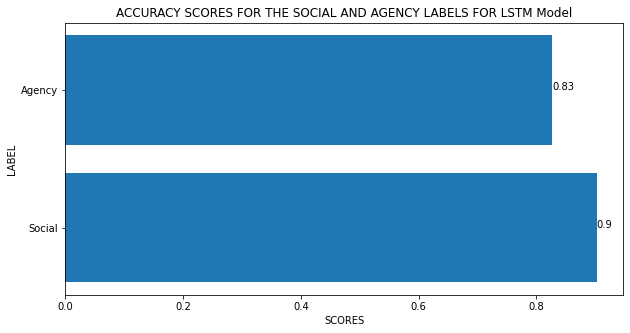

In [22]:
fig = plt.figure()
fig = plt.figure(figsize = (10, 5))
label = ['Social', 'Agency']
scores = [social_results[0], agency_results[0]]
plt.ylabel("LABEL")
plt.xlabel("SCORES")
plt.barh(label,scores)
plt.title("ACCURACY SCORES FOR THE SOCIAL AND AGENCY LABELS FOR LSTM Model")
for index, value in enumerate(scores):
    plt.text(value, index, str(round(value, 2)))
plt.show()

## BI-DIRECTIONAL LSTM MODEL

Method to bulid the bi-directional LSTM model

In [23]:
def getBidirectionalModel():
    # Input for variable-length sequences of integers
    inputs = Input(shape=(maxlen,))
    # Embedding layer
    x = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs)
    # Add bidirectional LSTMs
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)
    # Dense layer
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs)
    print(model.summary())
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    return model

In [24]:
model_LSTM_bi_di = getBidirectionalModel()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 300)           2178900   
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 3,012,693
Trainable params: 833,793
Non-trainable params: 2,178,900
_________________________________________________________________
None


### Fit the model for the Social label

In [25]:
history = model_LSTM_bi_di.fit(X_train, y_train_social, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
62/62 [==============================] - 14s 177ms/step - loss: 0.4643 - accuracy: 0.7656 - val_loss: 0.2744 - val_accuracy: 0.8937
Epoch 2/10
62/62 [==============================] - 10s 164ms/step - loss: 0.2640 - accuracy: 0.8952 - val_loss: 0.2508 - val_accuracy: 0.9033
Epoch 3/10
62/62 [==============================] - 10s 164ms/step - loss: 0.2293 - accuracy: 0.9127 - val_loss: 0.2471 - val_accuracy: 0.9048
Epoch 4/10
62/62 [==============================] - 10s 163ms/step - loss: 0.2153 - accuracy: 0.9202 - val_loss: 0.2349 - val_accuracy: 0.9144
Epoch 5/10
62/62 [==============================] - 10s 164ms/step - loss: 0.1920 - accuracy: 0.9276 - val_loss: 0.2594 - val_accuracy: 0.9128
Epoch 6/10
62/62 [==============================] - 10s 162ms/step - loss: 0.1579 - accuracy: 0.9418 - val_loss: 0.2624 - val_accuracy: 0.9003
Epoch 7/10
62/62 [==============================] - 10s 161ms/step - loss: 0.1527 - accuracy: 0.9465 - val_loss: 0.2607 - val_accuracy: 0.9063

In [26]:
predictions_bi_LSTM_social = model_LSTM_bi_di.predict(X_test)
print(predictions_bi_LSTM_social[:,0])

[9.96869087e-01 1.18997395e-02 2.39819288e-04 ... 9.86786723e-01
 2.17863917e-03 2.49305367e-03]


In [27]:
social_results_bi_LSTM = getResults(y_test_social, predictions_bi_LSTM_social)

The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [9.96869087e-01 1.18997395e-02 2.39819288e-04 8.73877287e-01
 9.96505022e-01]
First 5 values after the conversion : [1, 0, 0, 1, 1]

========== RESULTS ===========

Accuracy : 0.8981121115306419
Precision : 0.9249788672865596
F1_score : 0.9089398816322293
Recall : 0.893447642375995

===== CONFUSION MATRIX =====
[[6707  710]
 [1044 8754]]


### Fit the model for the Agency label

In [28]:
history = model_LSTM_bi_di.fit(X_train, y_train_agency, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
62/62 [==============================] - 10s 163ms/step - loss: 0.5150 - accuracy: 0.7843 - val_loss: 0.3993 - val_accuracy: 0.8272
Epoch 2/10
62/62 [==============================] - 10s 162ms/step - loss: 0.3578 - accuracy: 0.8449 - val_loss: 0.3659 - val_accuracy: 0.8489
Epoch 3/10
62/62 [==============================] - 10s 162ms/step - loss: 0.3226 - accuracy: 0.8634 - val_loss: 0.3593 - val_accuracy: 0.8504
Epoch 4/10
62/62 [==============================] - 10s 163ms/step - loss: 0.3045 - accuracy: 0.8715 - val_loss: 0.3519 - val_accuracy: 0.8458
Epoch 5/10
62/62 [==============================] - 10s 163ms/step - loss: 0.2865 - accuracy: 0.8797 - val_loss: 0.3645 - val_accuracy: 0.8413
Epoch 6/10
62/62 [==============================] - 10s 165ms/step - loss: 0.2633 - accuracy: 0.8876 - val_loss: 0.3653 - val_accuracy: 0.8383
Epoch 7/10
62/62 [==============================] - 10s 163ms/step - loss: 0.2351 - accuracy: 0.9017 - val_loss: 0.3771 - val_accuracy: 0.8469

In [29]:
predictions_bi_LSTM_agency = model_LSTM_bi_di.predict(X_test)
print(predictions_bi_LSTM_agency[:,0])

[0.9996569  0.99996233 0.9999887  ... 0.80111706 0.95497775 0.99995303]


In [30]:
agency_results_bi_LSTM = getResults(y_test_agency, predictions_bi_LSTM_agency)

The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [0.9996569  0.99996233 0.9999887  0.99998367 0.1023542 ]
First 5 values after the conversion : [1, 1, 1, 1, 0]

========== RESULTS ===========

Accuracy : 0.8155097298867267
Precision : 0.8485483620555815
F1_score : 0.873152807732247
Recall : 0.8992267193155643

===== CONFUSION MATRIX =====
[[ 944 6473]
 [3389 6409]]


### ACCURACY scores for social and agency label with BI-DIRECTIONAL LSTM model

<Figure size 432x288 with 0 Axes>

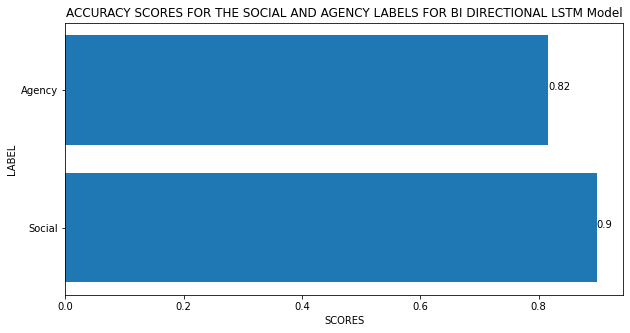

In [31]:
fig = plt.figure()
fig = plt.figure(figsize = (10, 5))
label = ['Social', 'Agency']
scores = [social_results_bi_LSTM[0], agency_results_bi_LSTM[0]]
plt.ylabel("LABEL")
plt.xlabel("SCORES")
plt.barh(label,scores)
plt.title("ACCURACY SCORES FOR THE SOCIAL AND AGENCY LABELS FOR BI DIRECTIONAL LSTM Model")
for index, value in enumerate(scores):
    plt.text(value, index, str(round(value, 2)))
plt.show()

## RESULTS

<Figure size 432x288 with 0 Axes>

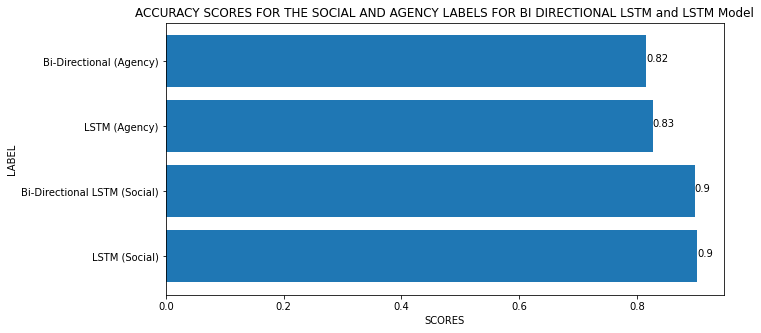

In [32]:
fig = plt.figure()
fig = plt.figure(figsize = (10, 5))
label = ['LSTM (Social)', 'Bi-Directional LSTM (Social)', 'LSTM (Agency)', 'Bi-Directional (Agency)']
scores = [social_results[0], social_results_bi_LSTM[0], agency_results[0], agency_results_bi_LSTM[0]]
plt.ylabel("LABEL")
plt.xlabel("SCORES")
plt.barh(label,scores)
plt.title("ACCURACY SCORES FOR THE SOCIAL AND AGENCY LABELS FOR BI DIRECTIONAL LSTM and LSTM Model")
for index, value in enumerate(scores):
    plt.text(value, index, str(round(value, 2)))
plt.show()

LSTM model outperforms Bi-Directinoal LSTM by a marginal val